# 基于PaddlePaddle的100项体育运动图像分类

---

![](https://ai-studio-static-online.cdn.bcebos.com/89fba7182bf648c7a1957d0a7d2a18c92186525d9e3a4006be39db821bafa6f7)


# 1.项目背景



随着我国体育产业的蓬勃发展，体育图像数据量呈指数增长，对体育图像进行有效的分类就非常重要，这既可以方便用户快速检索和访问，也便于工作人员对体育图像资料进行存储和管理，同时还有助于体育产业的智能化发展。此外，针对体育运动项目的图像分类应用还可以为观看体育赛事的大众人员进行项目辨识，也有利于对大家进行体育知识的相关普及。基于以上原因，因此便引申出了本项目的初步想法。

# 2.问题分析与解决

## 2.1 问题分析

让我们重新来审视和定义一下本项目要做的事情，这个问题可以大致被描述为使用PaddlePaddle框架来进行**多分类图像识别**。可能潜在的难点，也就是要解决的问题是，多个分类的类别之间数据集会存在不平衡不充分的问题，从而导致模型在训练过程中会存在某种归纳性偏好和倾向，最后使得模型的预测结果朝着某个数据量过大的结果接近。

## 2.2 解决方法

那么对于解决以上问题的方法，目前大致是思路是，
- 使用PaddlePadle框架自定义MyResNet模型，预设较为合适的模型进行训练
- 对于多类别之间的图片数据数量进行统计分析，通过数据增强和扩充的方式使得其类别与类别的样本数量之间尽可能接近。
- 通过多卡的大算力资源来进行足够次数的迭代训练。
- 选择合适的优化器以及学习率衰减方式。

# 3.数据准备

## 3.1 数据集介绍

本次项目使用的数据集主要以Kaggle平台的一个数据集为基准，在设置的100个运动分类中进行相应数量的数据扩充与数据增强。

![](https://ai-studio-static-online.cdn.bcebos.com/64706d7d1e444f5c9e12e5639561866972f3a7e4ff3c44e6b53864e3d7b2d9fd)


## 3.2 数据集分类类别

本项目使用数据集共包含100个类，详细可见如下：

| Sports Class          |
| --------------------- |
| air hockey            |
| ampute football       |
| archery               |
| arm wrestling         |
| axe throwing          |
| balance beam          |
| barell racing         |
| baseball              |
| basketball            |
| baton twirling        |
| bike polo             |
| billiards             |
| bmx                   |
| bobsled               |
| bowling               |
| boxing                |
| bull riding           |
| bungee jumping        |
| canoe slamon          |
| cheerleading          |
| chuckwagon racing     |
| cricket               |
| croquet               |
| curling               |
| disc golf             |
| fencing               |
| field hockey          |
| figure skating men    |
| figure skating pairs  |
| figure skating women  |
| fly fishing           |
| football              |
| formula 1 racing      |
| frisbee               |
| gaga                  |
| giant slalom          |
| golf                  |
| hammer throw          |
| hang gliding          |
| harness racing        |
| high jump             |
| hockey                |
| horse jumping         |
| horse racing          |
| horseshoe pitching    |
| hurdles               |
| hydroplane racing     |
| ice climbing          |
| ice yachting          |
| jai alai              |
| javelin               |
| jousting              |
| judo                  |
| lacrosse              |
| log rolling           |
| luge                  |
| motorcycle racing     |
| mushing               |
| nascar racing         |
| olympic wrestling     |
| parallel bar          |
| pole climbing         |
| pole dancing          |
| pole vault            |
| polo                  |
| pommel horse          |
| rings                 |
| rock climbing         |
| roller derby          |
| rollerblade racing    |
| rowing                |
| rugby                 |
| sailboat racing       |
| shot put              |
| shuffleboard          |
| sidecar racing        |
| ski jumping           |
| sky surfing           |
| skydiving             |
| snow boarding         |
| snowmobile racing     |
| speed skating         |
| steer wrestling       |
| sumo wrestling        |
| surfing               |
| swimming              |
| table tennis          |
| tennis                |
| track bicycle         |
| trapeze               |
| tug of war            |
| ultimate              |
| uneven bars           |
| volleyball            |
| water cycling         |
| water polo            |
| weightlifting         |
| wheelchair basketball |
| wheelchair racing     |
| wingsuit flying       |


目前已将制作好的数据集同步上传至AI Studio，并且挂载在本项目下，有需要的朋友们可以直接使用。

## 3.3 数据集可视化预览

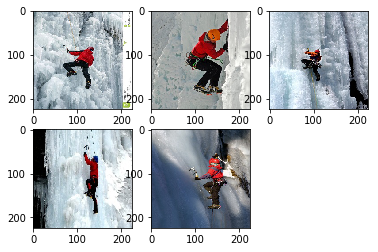

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

for i in range(1,6):
    plt.subplot(2,3,i)
    filename=os.path.join('work/ice_climbing/', str(i) +'.jpg')
    img=plt.imread(filename)
    plt.imshow(img)

# 4.模型设计

## 4.1 模型介绍

Resnet分类网络是当前应用最为广泛的CNN特征提取网络。
我们的一般印象当中，深度学习愈是深（复杂，参数多）愈是有着更强的表达能力。凭着这一基本准则CNN分类网络自Alexnet的7层发展到了VGG的16乃至19层，后来更有了Googlenet的22层。可后来我们发现深度CNN网络达到一定深度后再一味地增加层数并不能带来进一步地分类性能提高，反而会招致网络收敛变得更慢，test dataset的分类准确率也变得更差。排除数据集过小带来的模型过拟合等问题后，我们发现过深的网络仍然还会使分类准确度下降（相对于较浅些的网络而言）。
简单地增加网络层数会导致梯度消失和梯度爆炸，因此，人们提出了正则化初始化和中间的正则化层(Batch Normalization)，但是 又引发了另外一个问题——退化问题，即随着网络层数地增加，训练集上的准确率却饱和甚至下降。这个问题并不是由过拟合(overfit)造成的，因为过拟合表现应该表现为在训练集上变现更好。
residual learning的block是通过使用多个有参层来学习输入输出之间的残差表示，而非像一般CNN网络（如Alexnet/VGG等）那样使用有参层来直接尝试学习输入、输出之间的映射。实验表明使用一般意义上的有参层来直接学习残差比直接学习输入、输出间映射要容易得多（收敛速度更快），也有效得多（可通过使用更多的层来达到更高的分类精度）。

**网络结构**

- basic模式：
简单地将X相对Y缺失的通道直接补零从而使其能够相对齐的方式，以两个3*3的卷积网络串接在一起作为一个残差块；
- bottleneck模式：通过使用1x1的conv来表示Ws映射从而使得最终输入与输出的通道达到一致的方式。1*1,3*3,1*1三个卷积网络串接在一起作为一个残差模块。加入1*1的卷积核巧妙地缩减或扩张feature map维度从而使得我们的3x3 conv的filters数目不受外界即上一层输入的影响，自然它的输出也不会影响到下一层module，增加非线性和减小输出的深度以减小计算成本。不过它纯是为了节省计算时间进而缩小整个模型训练所需的时间而设计的，对最终的模型精度并无影响。

![](https://ai-studio-static-online.cdn.bcebos.com/5ccf9aef27244bec91b725ce1a4d74e246a81475463242eebacedc1901996b05)


## 4.2 模型定义实现

此处为初步定义，无需运行，执行代码在下一个部分。


```python
class ResNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, layers=50, class_dim=100):
        super(ResNet, self).__init__(name_scope)

        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            depth = [3, 4, 6, 3]
        elif layers == 101:
            depth = [3, 4, 23, 3]
        elif layers == 152:
            depth = [3, 8, 36, 3]
        num_filters = [64, 128, 256, 512]

        self.conv = ConvBNLayer(
            self.full_name(),
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = Pool2D(
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        self.full_name(),
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1,
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        self.pool2d_avg = Pool2D(pool_size=7, pool_type='avg', global_pooling=True)

        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)

        self.out = Linear(input_dim=num_channels,
                          output_dim=class_dim,
                          act='softmax',
                          param_attr=fluid.param_attr.ParamAttr(
                              initializer=fluid.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs, label=None):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = fluid.layers.reshape(x=y, shape=[-1, y.shape[1]])
        y = self.out(y)
        if label is not None:
            acc = fluid.layers.accuracy(input=y, label=label)
            return y, acc
        else:
            return y
```



# 5.模型训练

## 5.1 准备工作

### 5.1.1 预先导入库

In [2]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
import matplotlib.pyplot as plt

### 5.1.2 预置训练参数

In [3]:
'''
参数配置
'''
batch_size = 32  ##
num_epochs = 40 ##后面有改动
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    "class_dim": 100,                                          #分类数
    "src_path":"/home/aistudio/data/data129412/sports_trains.zip",            #原始数据集路径
    "target_path":"/home/aistudio/data/dataset",              #要解压的路径 
    "train_list_path": "./train_data.txt",                    #train_data.txt路径
    "eval_list_path": "./val_data.txt",                       #eval_data.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "image_count": -1,                                        # 训练图片数量
    "train_batch_size": batch_size,                           #训练时每个批次的大小
    "num_epochs":  num_epochs,                                #训练轮数
    "mode": "train",                                          #工作模式
                                            
    "network_resnet": {                 #ResNet
        "layer": 50                     #ResNet的层数
    },                                              
    "continue_train": False,            # 是否接着上一次保存的参数接着训练
    "regenerat_imgs": False,            # 是否生成增强图像文件，True强制重新生成，慢
    "mean_rgb": [127.5, 127.5, 127.5],  # 常用图片的三通道均值，通常来说需要先对训练数据做统计，此处仅取中间值
    "use_gpu": True,
    "use_image_enhance": False,
    "image_enhance_strategy": {  # 图像增强相关策略
        "need_distort": False,    # 是否启用图像颜色增强
        "need_rotate": False,     # 是否需要增加随机角度
        "need_crop": False,       # 是否要增加裁剪
        "need_flip": False,       # 是否要增加水平随机翻转
        "need_expand": False,     # 是否要增加扩展
        "expand_prob": 0.5,
        "expand_max_ratio": 4,
        "hue_prob": 0.5,
        "hue_delta": 18,
        "contrast_prob": 0.5,
        "contrast_delta": 0.5,
        "saturation_prob": 0.5,
        "saturation_delta": 0.5,
        "brightness_prob": 0.5,
        "brightness_delta": 0.125
    },
    "learning_strategy": {                                    #优化函数相关的配置
        #"lr": 0.00125,                                        #超参数学习率        
        "lr": 0.000125,                                        #超参数学习率        
        "name": "cosine_decay",
        "batch_size": batch_size,
        "epochs": [40, 80, 100],
        "steps": [0.1, 0.01, 0.001, 0.0001]
    },  
    "early_stop": {  
        "sample_frequency": 50,  
        "successive_limit": 3,  
        "good_acc1": 0.9975 #0.92  
    },  
    "rms_strategy": {  
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],  
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]  
    },  
    "momentum_strategy": {  
        #"learning_rate": 0.001,
        "learning_rate": 0.0001,    
        "lr_epochs": [20, 40, 60, 80, 100],  
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]  
    },  
    "sgd_strategy": {  
        "learning_rate": 0.001,
        "lr_epochs": [20, 40, 60, 80, 100],  
        "lr_decay": [1, 0.5, 0.25, 0.1, 0.01, 0.002]  
    },  
    "adam_strategy": {  
        "learning_rate": 0.002          
    }, 
    "adamax_strategy": {  
        "learning_rate": 0.00125  
    }      
}

### 5.1.3 功能函数定义

#### 5.1.3.1 定义解压数据集函数

In [4]:
def unzip_data(src_path,target_path):

    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''

    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")


#### 5.1.3.2 定义列表生成函数

In [7]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = os.path.join(data_list_path,class_dir)
            print(path)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                    all_class_images += 1                                   #所有类图片的数目
                    #
                    # 验证集不用做也不能做增强
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                    #
                    all_class_images += 1                                   #所有类图片的数目                    
                    #

                class_sum += 1                                          #每类图片的数目
                ##all_class_images += 1                                   #所有类图片的数目
            
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
    #乱序        
    random.shuffle(trainer_list) 
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

#### 5.1.3.3 自定义数据读取器

In [8]:
# reader
def custom_reader(file_list,mode):
    '''
    自定义data_reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            ## 打乱次序
            random.shuffle(lines)
            for line in lines:
                if mode == 'train' or mode == 'eval':
                    img_path, lab = line.strip().split('\t')
                    img = Image.open(img_path) 
                    if img.mode != 'RGB': 
                        img = img.convert('RGB') 
                    #使用在线增强方式，不用的话，把下一段代码注释掉
                    #验证模式下不用增强，所以加了一个工作模式条件判断
                    #"""                    
                    if mode == 'train': 
                        #在线增强方式：
                        if (train_parameters["use_image_enhance"]):
                            img = preprocess(img, mode)  #只有在'train'模式下才执行图像增强
                    #"""
                    #图像缩放到指定大小，VGG是3x224x224
                    img = img.resize((224, 224), Image.ANTIALIAS)  ##BILINEAR
                    img = np.array(img).astype('float32') 
                    #图像数据按照所需要的格式重新排列
                    img = img.transpose((2, 0, 1))  # HWC to CHW 
                    img = img/255.0                   # 像素值归一化 
                    yield img, int(lab) 
                elif mode == 'test':
                    img_path = line.strip()
                    img = Image.open(img_path)
                    img = img.resize((224, 224), Image.ANTIALIAS)
                    img = np.array(img).astype('float32') 
                    img = img.transpose((2, 0, 1))  # HWC to CHW 
                    img = img/255.0                   # 像素值归一化                     
                    yield img                    
    return reader

#### 5.1.3.4 定义可视化绘图函数

In [ ]:
'''
PLOT画图
'''


def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("loss/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show() 

### 5.1.4 处理数据集

#### 5.1.4.1 解压并生成列表

In [10]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)
/home/aistudio/data/dataset/train
{'input_size': [3, 224, 224], 'class_dim': 100, 'src_path': '/home/aistudio/data/data129404/sports_trains.zip', 'target_path': '/home/aistudio/data/dataset', 'train_list_path': './train_data.txt', 'eval_list_path': './val_data.txt', 'readme_path': '/home/aistudio/data/readme.json', 'label_dict': {'0': 'train'}, 'image_count': -1, 'train_batch_size': 32, 'num_epochs': 100, 'mode': 'train', 'network_resnet': {'layer': 50}, 'continue_train': False, 'regenerat_imgs': False, 'mean_rgb': [127.5, 127.5, 127.5], 'use_gpu': True, 'use_image_enhance': False, 'image_enhance_strategy': {'need_distort': False, 'need_rotate': False, 'need_crop': False, 'need_flip': False, 'need_expand': False, 'expand_prob': 0.5, 'expand_max_ratio': 4, 'hue_prob': 0.5, 'hue_delta': 18, 'contrast_prob': 0.5, 'contrast_delta': 0.5, 'saturation_prob': 0.5, 'saturation_delta': 0.5, 'brightness_prob': 0.5, 'brightness_delta': 0.125}, 'learning_strategy': {'lr': 0.000125, 'name': 'cosine_decay', 'batch_size': 32, 'epochs': [40, 80, 100], 'steps': [0.1, 0.01, 0.001, 0.0001]}, 'early_stop': {'sample_frequency': 50, 'successive_limit': 3, 'good_acc1': 0.9975}, 'rms_strategy': {'learning_rate': 0.001, 'lr_epochs': [20, 40, 60, 80, 100], 'lr_decay': [1, 0.5, 0.25, 0.1, 0.01, 0.002]}, 'momentum_strategy': {'learning_rate': 0.0001, 'lr_epochs': [20, 40, 60, 80, 100], 'lr_decay': [1, 0.5, 0.25, 0.1, 0.01, 0.002]}, 'sgd_strategy': {'learning_rate': 0.001, 'lr_epochs': [20, 40, 60, 80, 100], 'lr_decay': [1, 0.5, 0.25, 0.1, 0.01, 0.002]}, 'adam_strategy': {'learning_rate': 0.002}, 'adamax_strategy': {'learning_rate': 0.00125}}

文件已解压
/home/aistudio/data/dataset/surfing
/home/aistudio/data/dataset/fly_fishing
/home/aistudio/data/dataset/jai_alai
/home/aistudio/data/dataset/water_polo
/home/aistudio/data/dataset/hammer_throw
/home/aistudio/data/dataset/shot_put
/home/aistudio/data/dataset/rock_climbing
/home/aistudio/data/dataset/croquet
/home/aistudio/data/dataset/judo
/home/aistudio/data/dataset/hang_gliding
/home/aistudio/data/dataset/ice_yachting
/home/aistudio/data/dataset/cheerleading
/home/aistudio/data/dataset/billiards
/home/aistudio/data/dataset/rings
/home/aistudio/data/dataset/field_hockey
/home/aistudio/data/dataset/trapeze
/home/aistudio/data/dataset/pommel_horse
/home/aistudio/data/dataset/boxing
/home/aistudio/data/dataset/olympic_wrestling
/home/aistudio/data/dataset/pole_vault
/home/aistudio/data/dataset/pole_dancing
/home/aistudio/data/dataset/axe_throwing
/home/aistudio/data/dataset/cricket
/home/aistudio/data/dataset/frisbee
/home/aistudio/data/dataset/bull_riding
/home/aistudio/data/datase

NameError: name 'home' is not defined

#### 5.1.4.2 划分数据集

In [11]:
 '''
构造数据提供器
'''
#训练集和验证集调用同样的函数，但是工作模式这个参数不一样。
train_reader = paddle.batch(custom_reader(train_list_path, 'train'),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(custom_reader(eval_list_path, 'eval'),
                            batch_size=batch_size,
                            drop_last=True)
# 定义网络计算参数
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

## 5.2 模型定义

### 5.2.1 定义ResNet网络

In [13]:
# ResNet网络定义
import numpy as np
import argparse
import ast
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable
from paddle.fluid import framework
import math
import sys
from paddle.fluid.param_attr import ParamAttr


class ConvBNLayer(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_channels,
                 num_filters,
                 filter_size,
                 stride=1,
                 groups=1,
                 act=None):
        super(ConvBNLayer, self).__init__(name_scope)

        self._conv = Conv2D(
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=filter_size,
            stride=stride,
            padding=(filter_size - 1) // 2,
            groups=groups,
            act=None,
            bias_attr=False)

        self._batch_norm = BatchNorm(num_filters, act=act)

    def forward(self, inputs):
        y = self._conv(inputs)
        y = self._batch_norm(y)

        return y


class BottleneckBlock(fluid.dygraph.Layer):
    def __init__(self,
                 name_scope,
                 num_channels,
                 num_filters,
                 stride,
                 shortcut=True):
        super(BottleneckBlock, self).__init__(name_scope)

        self.conv0 = ConvBNLayer(
            self.full_name(),
            num_channels=num_channels,
            num_filters=num_filters,
            filter_size=1,
            act='relu')
        self.conv1 = ConvBNLayer(
            self.full_name(),
            num_channels=num_filters,
            num_filters=num_filters,
            filter_size=3,
            stride=stride,
            act='relu')
        self.conv2 = ConvBNLayer(
            self.full_name(),
            num_channels=num_filters,
            num_filters=num_filters * 4,
            filter_size=1,
            act=None)

        if not shortcut:
            self.short = ConvBNLayer(
                self.full_name(),
                num_channels=num_channels,
                num_filters=num_filters * 4,
                filter_size=1,
                stride=stride)

        self.shortcut = shortcut

        self._num_channels_out = num_filters * 4

    def forward(self, inputs):
        y = self.conv0(inputs)
        conv1 = self.conv1(y)
        conv2 = self.conv2(conv1)

        if self.shortcut:
            short = inputs
        else:
            short = self.short(inputs)

        y = fluid.layers.elementwise_add(x=short, y=conv2)

        layer_helper = LayerHelper(self.full_name(), act='relu')
        return layer_helper.append_activation(y)


class ResNet(fluid.dygraph.Layer):
    def __init__(self, name_scope, layers=50, class_dim=100):
        super(ResNet, self).__init__(name_scope)

        self.layers = layers
        supported_layers = [50, 101, 152]
        assert layers in supported_layers, \
            "supported layers are {} but input layer is {}".format(supported_layers, layers)

        if layers == 50:
            depth = [3, 4, 6, 3]
        elif layers == 101:
            depth = [3, 4, 23, 3]
        elif layers == 152:
            depth = [3, 8, 36, 3]
        num_filters = [64, 128, 256, 512]

        self.conv = ConvBNLayer(
            self.full_name(),
            num_channels=3,
            num_filters=64,
            filter_size=7,
            stride=2,
            act='relu')
        self.pool2d_max = Pool2D(
            pool_size=3,
            pool_stride=2,
            pool_padding=1,
            pool_type='max')

        self.bottleneck_block_list = []
        num_channels = 64
        for block in range(len(depth)):
            shortcut = False
            for i in range(depth[block]):
                bottleneck_block = self.add_sublayer(
                    'bb_%d_%d' % (block, i),
                    BottleneckBlock(
                        self.full_name(),
                        num_channels=num_channels,
                        num_filters=num_filters[block],
                        stride=2 if i == 0 and block != 0 else 1,
                        shortcut=shortcut))
                num_channels = bottleneck_block._num_channels_out
                self.bottleneck_block_list.append(bottleneck_block)
                shortcut = True

        self.pool2d_avg = Pool2D(pool_size=7, pool_type='avg', global_pooling=True)

        import math
        stdv = 1.0 / math.sqrt(2048 * 1.0)

        self.out = Linear(input_dim=num_channels,
                          output_dim=class_dim,
                          act='softmax',
                          param_attr=fluid.param_attr.ParamAttr(
                              initializer=fluid.initializer.Uniform(-stdv, stdv)))

    def forward(self, inputs, label=None):
        y = self.conv(inputs)
        y = self.pool2d_max(y)
        for bottleneck_block in self.bottleneck_block_list:
            y = bottleneck_block(y)
        y = self.pool2d_avg(y)
        y = fluid.layers.reshape(x=y, shape=[-1, y.shape[1]])
        y = self.out(y)
        if label is not None:
            acc = fluid.layers.accuracy(input=y, label=label)
            return y, acc
        else:
            return y

### 5.2.2 测试网络参数

In [14]:
# 看一下网络参数
with fluid.dygraph.guard():
    network = ResNet('resnet', layers=50, class_dim=25)
    img = np.zeros([1, 3, 224, 224]).astype('float32')
    img = fluid.dygraph.to_variable(img)
    outs = network(img).numpy()
    print(outs)

W0225 16:20:27.413607   150 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0225 16:20:27.418663   150 device_context.cc:465] device: 0, cuDNN Version: 7.6.


[[0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
  0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]]


## 5.3 定义评估函数

In [15]:
#定义eval_net函数
print(train_parameters)

def eval_net(reader, model):
    acc_set = []
    
    for batch_id, data in enumerate(reader()):
        dy_x_data = np.array([x[0] for x in data]).astype('float32')
        y_data = np.array([x[1] for x in data]).astype('int')
        y_data = y_data[:, np.newaxis]
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)
        label.stop_gradient = True
        prediction, acc = model(img, label)

        #        out, acc = model(img, label)
        #        lab = np.argsort(out.numpy())
        #        accs.append(acc.numpy()[0]) 

        acc_set.append(float(acc.numpy()))

        # get test acc and loss
    acc_val_mean = np.array(acc_set).mean()

    return acc_val_mean 

{'input_size': [3, 224, 224], 'class_dim': 101, 'src_path': '/home/aistudio/data/data129412/sports_trains.zip', 'target_path': '/home/aistudio/data/dataset', 'train_list_path': './train_data.txt', 'eval_list_path': './val_data.txt', 'readme_path': '/home/aistudio/data/readme.json', 'label_dict': {'0': 'surfing', '1': 'fly_fishing', '2': 'jai_alai', '3': 'water_polo', '4': 'hammer_throw', '5': 'shot_put', '6': 'rock_climbing', '7': 'croquet', '8': 'judo', '9': 'hang_gliding', '10': 'ice_yachting', '11': 'cheerleading', '12': 'billiards', '13': 'rings', '14': 'field_hockey', '15': 'trapeze', '16': 'pommel_horse', '17': 'boxing', '18': 'olympic_wrestling', '19': 'pole_vault', '20': 'pole_dancing', '21': 'axe_throwing', '22': 'cricket', '23': 'frisbee', '24': 'bull_riding', '25': 'gaga', '26': 'lacrosse', '27': 'nascar_racing', '28': 'mushing', '29': 'sky_surfing', '30': 'hurdles', '31': 'curling', '32': 'jousting', '33': 'fencing', '34': 'ice_climbing', '35': 'ultimate', '36': 'rollerblad

## 5.4 模型训练

### 5.4.1 开始训练

class_dims: 101
label_dict: {'0': 'surfing', '1': 'fly_fishing', '2': 'jai_alai', '3': 'water_polo', '4': 'hammer_throw', '5': 'shot_put', '6': 'rock_climbing', '7': 'croquet', '8': 'judo', '9': 'hang_gliding', '10': 'ice_yachting', '11': 'cheerleading', '12': 'billiards', '13': 'rings', '14': 'field_hockey', '15': 'trapeze', '16': 'pommel_horse', '17': 'boxing', '18': 'olympic_wrestling', '19': 'pole_vault', '20': 'pole_dancing', '21': 'axe_throwing', '22': 'cricket', '23': 'frisbee', '24': 'bull_riding', '25': 'gaga', '26': 'lacrosse', '27': 'nascar_racing', '28': 'mushing', '29': 'sky_surfing', '30': 'hurdles', '31': 'curling', '32': 'jousting', '33': 'fencing', '34': 'ice_climbing', '35': 'ultimate', '36': 'rollerblade_racing', '37': 'hockey', '38': 'bobsled', '39': 'formula_1_racing', '40': 'skydiving', '41': 'hydroplane_racing', '42': 'horse_racing', '43': 'bmx', '44': 'high_jump', '45': 'table_tennis', '46': 'track_bicycle', '47': 'snow_boarding', '48': 'disc_golf', '49': 'balan

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


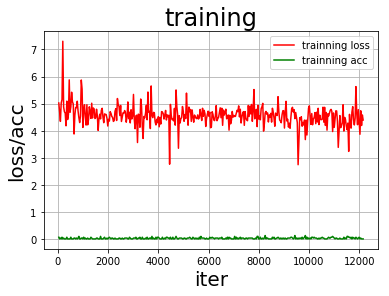

epoch   1 step    0: loss: 4.344422, acc: 0.093750
epoch   1 step  100: loss: 4.448766, acc: 0.031250
epoch   1 step  200: loss: 4.282977, acc: 0.062500
epoch   1 step  300: loss: 4.495663, acc: 0.062500
  train_pass:1,eval_acc=0.073401
    current best_eval_acc=0.073401 in No.1 epoch
    MyResNet_best模型已保存


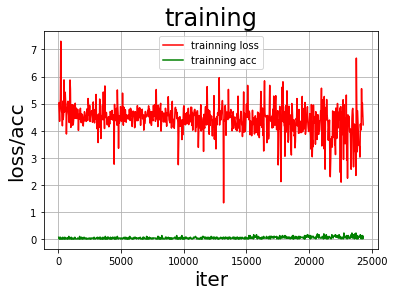

epoch   2 step    0: loss: 4.075826, acc: 0.031250
epoch   2 step  100: loss: 4.068564, acc: 0.062500
epoch   2 step  200: loss: 3.812817, acc: 0.093750
epoch   2 step  300: loss: 3.868899, acc: 0.156250
  train_pass:2,eval_acc=0.129360
    current best_eval_acc=0.129360 in No.2 epoch
    MyResNet_best模型已保存


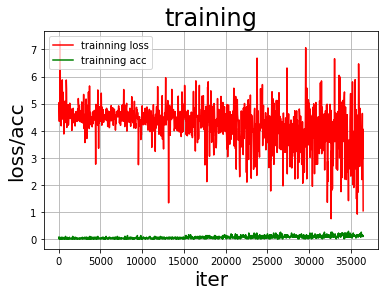

epoch   3 step    0: loss: 3.906095, acc: 0.093750
epoch   3 step  100: loss: 3.516611, acc: 0.156250
epoch   3 step  200: loss: 3.375475, acc: 0.187500
epoch   3 step  300: loss: 3.539986, acc: 0.218750
  train_pass:3,eval_acc=0.172965
    current best_eval_acc=0.172965 in No.3 epoch
    MyResNet_best模型已保存


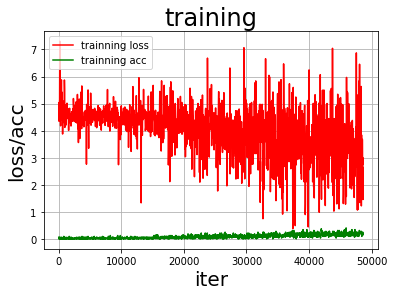

epoch   4 step    0: loss: 3.049354, acc: 0.218750
epoch   4 step  100: loss: 3.273822, acc: 0.125000
epoch   4 step  200: loss: 2.947639, acc: 0.250000
epoch   4 step  300: loss: 2.915750, acc: 0.312500
  train_pass:4,eval_acc=0.272529
    current best_eval_acc=0.272529 in No.4 epoch
    MyResNet_best模型已保存


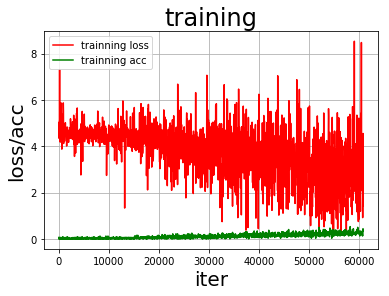

epoch   5 step    0: loss: 2.433669, acc: 0.375000
epoch   5 step  100: loss: 2.433596, acc: 0.312500
epoch   5 step  200: loss: 2.674452, acc: 0.312500
epoch   5 step  300: loss: 2.947261, acc: 0.312500
  train_pass:5,eval_acc=0.263808


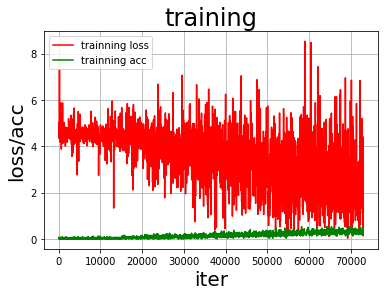

epoch   6 step    0: loss: 2.350182, acc: 0.468750
epoch   6 step  100: loss: 2.542652, acc: 0.312500
epoch   6 step  200: loss: 1.980594, acc: 0.562500
epoch   6 step  300: loss: 2.405549, acc: 0.343750
  train_pass:6,eval_acc=0.326308
    current best_eval_acc=0.326308 in No.6 epoch
    MyResNet_best模型已保存


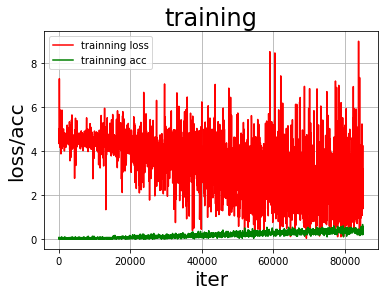

epoch   7 step    0: loss: 2.137000, acc: 0.531250
epoch   7 step  100: loss: 2.053178, acc: 0.531250
epoch   7 step  200: loss: 1.890055, acc: 0.500000
epoch   7 step  300: loss: 1.976931, acc: 0.562500
  train_pass:7,eval_acc=0.316134


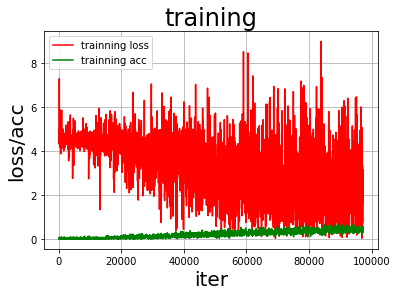

epoch   8 step    0: loss: 2.184583, acc: 0.468750
epoch   8 step  100: loss: 1.469053, acc: 0.593750
epoch   8 step  200: loss: 2.104154, acc: 0.375000
epoch   8 step  300: loss: 2.344691, acc: 0.375000
  train_pass:8,eval_acc=0.335029
    current best_eval_acc=0.335029 in No.8 epoch
    MyResNet_best模型已保存


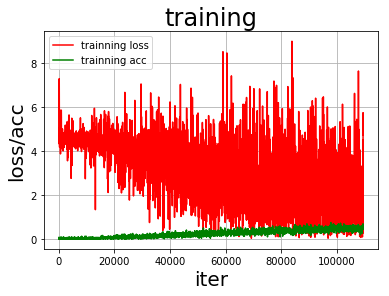

epoch   9 step    0: loss: 1.985113, acc: 0.531250
epoch   9 step  100: loss: 1.582901, acc: 0.625000
epoch   9 step  200: loss: 1.733045, acc: 0.593750
epoch   9 step  300: loss: 1.923684, acc: 0.531250
  train_pass:9,eval_acc=0.288517


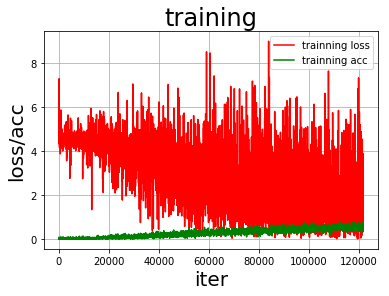

epoch  10 step    0: loss: 1.243493, acc: 0.750000
epoch  10 step  100: loss: 1.498772, acc: 0.625000
epoch  10 step  200: loss: 1.648585, acc: 0.562500
epoch  10 step  300: loss: 1.802282, acc: 0.500000
  train_pass:10,eval_acc=0.351744
    current best_eval_acc=0.351744 in No.10 epoch
    MyResNet_best模型已保存


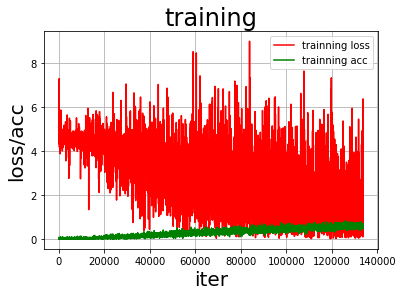

epoch  11 step    0: loss: 1.223046, acc: 0.687500
epoch  11 step  100: loss: 1.235830, acc: 0.625000
epoch  11 step  200: loss: 1.303589, acc: 0.625000
epoch  11 step  300: loss: 1.311808, acc: 0.625000
  train_pass:11,eval_acc=0.382267
    current best_eval_acc=0.382267 in No.11 epoch
    MyResNet_best模型已保存


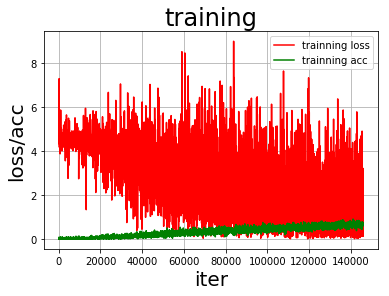

epoch  12 step    0: loss: 1.251099, acc: 0.750000
epoch  12 step  100: loss: 1.416606, acc: 0.625000
epoch  12 step  200: loss: 0.926003, acc: 0.812500
epoch  12 step  300: loss: 1.255163, acc: 0.718750
  train_pass:12,eval_acc=0.384448
    current best_eval_acc=0.384448 in No.12 epoch
    MyResNet_best模型已保存


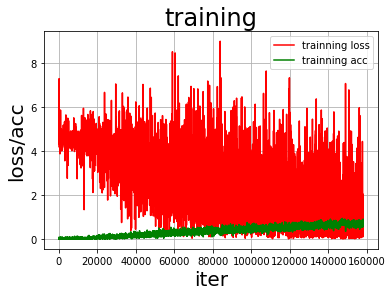

epoch  13 step    0: loss: 0.781621, acc: 0.843750
epoch  13 step  100: loss: 1.099365, acc: 0.750000
epoch  13 step  200: loss: 1.258689, acc: 0.750000
epoch  13 step  300: loss: 0.953034, acc: 0.656250
  train_pass:13,eval_acc=0.297238


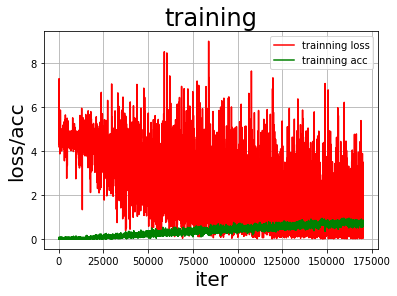

epoch  14 step    0: loss: 0.884460, acc: 0.812500
epoch  14 step  100: loss: 0.936706, acc: 0.781250
epoch  14 step  200: loss: 0.788968, acc: 0.750000
epoch  14 step  300: loss: 0.816725, acc: 0.781250
  train_pass:14,eval_acc=0.260174


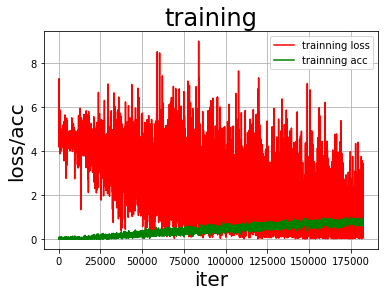

epoch  15 step    0: loss: 0.678001, acc: 0.906250
epoch  15 step  100: loss: 0.522393, acc: 0.937500
epoch  15 step  200: loss: 0.842329, acc: 0.781250
epoch  15 step  300: loss: 0.607992, acc: 0.875000
  train_pass:15,eval_acc=0.359012


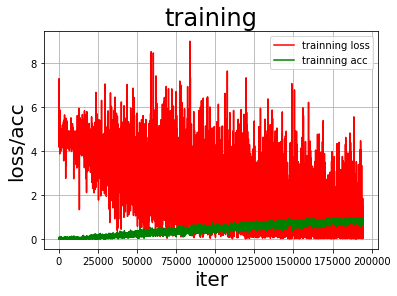

epoch  16 step    0: loss: 0.449771, acc: 0.937500
epoch  16 step  100: loss: 0.480454, acc: 0.937500
epoch  16 step  200: loss: 0.558093, acc: 0.906250
epoch  16 step  300: loss: 1.220764, acc: 0.718750
  train_pass:16,eval_acc=0.297238


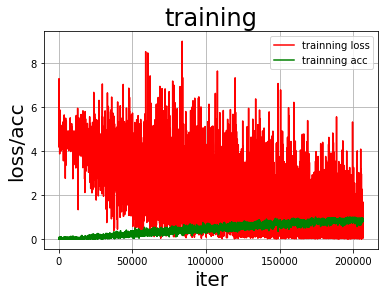

epoch  17 step    0: loss: 0.535301, acc: 0.875000
epoch  17 step  100: loss: 0.539146, acc: 0.843750
epoch  17 step  200: loss: 0.586734, acc: 0.875000
epoch  17 step  300: loss: 0.786399, acc: 0.812500
  train_pass:17,eval_acc=0.351744


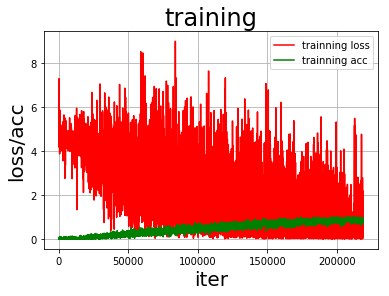

epoch  18 step    0: loss: 0.325029, acc: 1.000000
epoch  18 step  100: loss: 0.534391, acc: 0.906250
epoch  18 step  200: loss: 0.385013, acc: 0.937500
epoch  18 step  300: loss: 0.464074, acc: 0.906250
  train_pass:18,eval_acc=0.327035


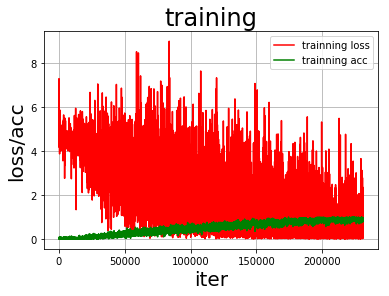

epoch  19 step    0: loss: 0.325740, acc: 0.968750
epoch  19 step  100: loss: 0.687822, acc: 0.781250
epoch  19 step  200: loss: 0.539572, acc: 0.906250
epoch  19 step  300: loss: 0.676311, acc: 0.906250
  train_pass:19,eval_acc=0.348110


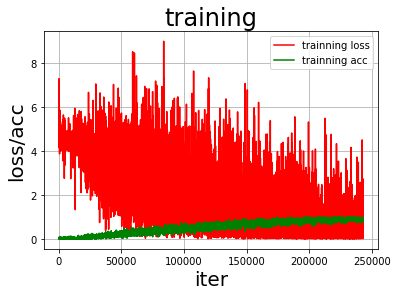

epoch  20 step    0: loss: 0.317012, acc: 0.937500
epoch  20 step  100: loss: 0.556313, acc: 0.937500
epoch  20 step  200: loss: 0.289290, acc: 1.000000
epoch  20 step  300: loss: 0.733185, acc: 0.812500
  train_pass:20,eval_acc=0.271802


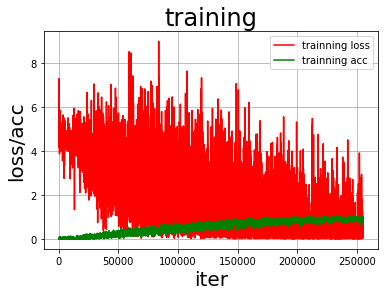

epoch  21 step    0: loss: 0.211276, acc: 0.968750
epoch  21 step  100: loss: 0.346784, acc: 0.906250
epoch  21 step  200: loss: 0.527674, acc: 0.875000
epoch  21 step  300: loss: 0.559526, acc: 0.875000
  train_pass:21,eval_acc=0.330669


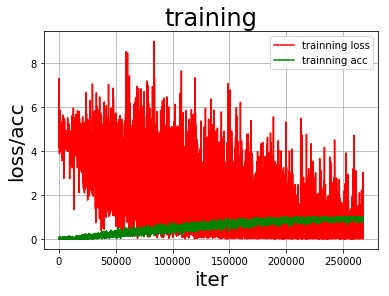

epoch  22 step    0: loss: 0.353175, acc: 0.937500
epoch  22 step  100: loss: 0.255739, acc: 1.000000
epoch  22 step  200: loss: 0.272417, acc: 0.968750
epoch  22 step  300: loss: 0.559926, acc: 0.906250
  train_pass:22,eval_acc=0.327035


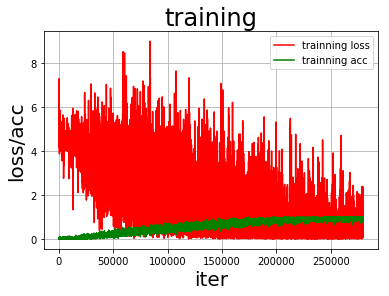

epoch  23 step    0: loss: 0.351653, acc: 1.000000
epoch  23 step  100: loss: 0.262214, acc: 0.937500
epoch  23 step  200: loss: 0.240450, acc: 0.968750
epoch  23 step  300: loss: 0.582008, acc: 0.875000
  train_pass:23,eval_acc=0.250000


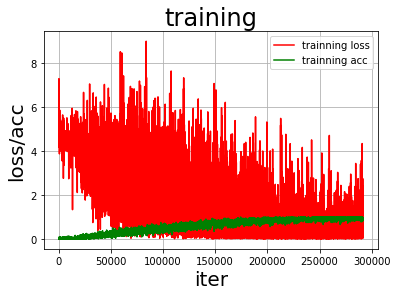

epoch  24 step    0: loss: 0.279737, acc: 0.968750
epoch  24 step  100: loss: 0.161097, acc: 1.000000
epoch  24 step  200: loss: 0.255107, acc: 1.000000
epoch  24 step  300: loss: 0.621383, acc: 0.906250
  train_pass:24,eval_acc=0.321221


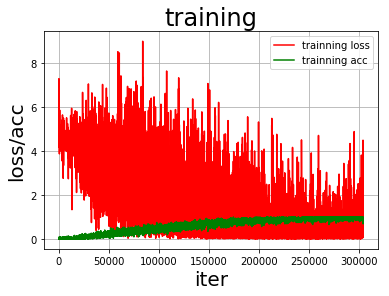

epoch  25 step    0: loss: 0.314221, acc: 1.000000
epoch  25 step  100: loss: 0.399853, acc: 0.937500
epoch  25 step  200: loss: 0.381395, acc: 0.968750
epoch  25 step  300: loss: 0.542223, acc: 0.968750
  train_pass:25,eval_acc=0.336483


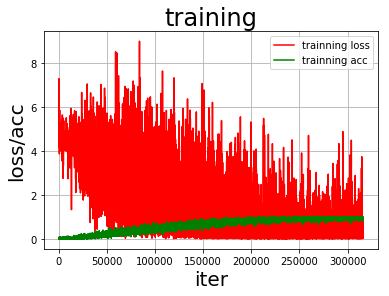

epoch  26 step    0: loss: 0.311982, acc: 1.000000
epoch  26 step  100: loss: 0.400231, acc: 0.937500
epoch  26 step  200: loss: 0.298036, acc: 1.000000
epoch  26 step  300: loss: 0.424639, acc: 0.906250
  train_pass:26,eval_acc=0.288517


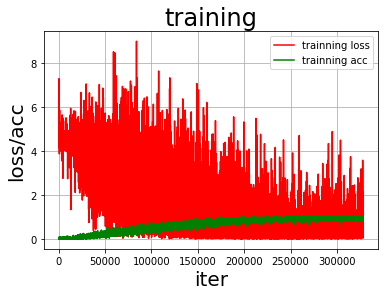

epoch  27 step    0: loss: 0.382634, acc: 1.000000
epoch  27 step  100: loss: 0.374762, acc: 1.000000
epoch  27 step  200: loss: 0.279121, acc: 1.000000
epoch  27 step  300: loss: 0.660335, acc: 0.875000
  train_pass:27,eval_acc=0.362645


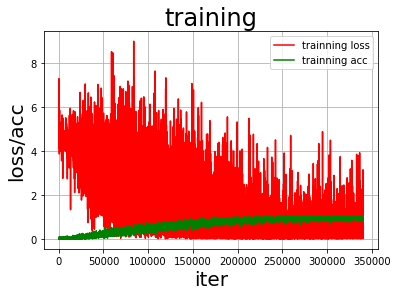

epoch  28 step    0: loss: 0.263456, acc: 1.000000
epoch  28 step  100: loss: 0.328578, acc: 1.000000
epoch  28 step  200: loss: 0.384087, acc: 0.968750
epoch  28 step  300: loss: 0.587198, acc: 0.906250
  train_pass:28,eval_acc=0.292151


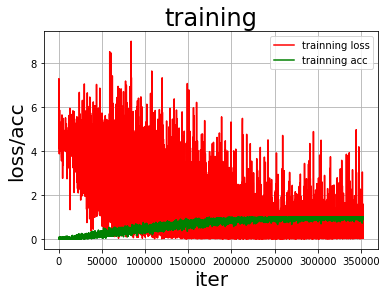

epoch  29 step    0: loss: 0.387571, acc: 1.000000
epoch  29 step  100: loss: 0.451020, acc: 0.937500
epoch  29 step  200: loss: 0.540194, acc: 0.937500
epoch  29 step  300: loss: 0.547651, acc: 0.937500
  train_pass:29,eval_acc=0.322674


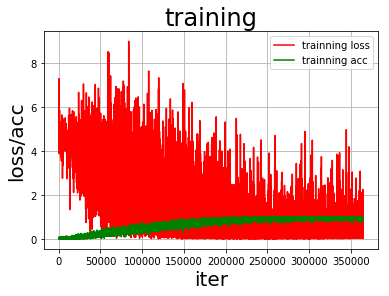

epoch  30 step    0: loss: 0.381267, acc: 0.937500
epoch  30 step  100: loss: 0.410548, acc: 1.000000
epoch  30 step  200: loss: 0.495119, acc: 0.937500
epoch  30 step  300: loss: 0.570709, acc: 1.000000
  train_pass:30,eval_acc=0.210756


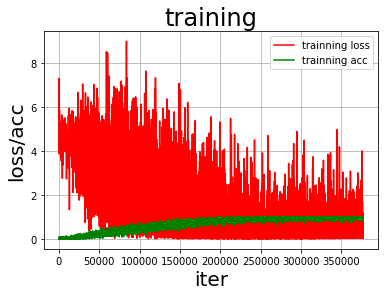

epoch  31 step    0: loss: 0.567516, acc: 0.968750
epoch  31 step  100: loss: 0.405712, acc: 0.968750
epoch  31 step  200: loss: 0.522616, acc: 1.000000
epoch  31 step  300: loss: 0.574629, acc: 0.968750
  train_pass:31,eval_acc=0.333576


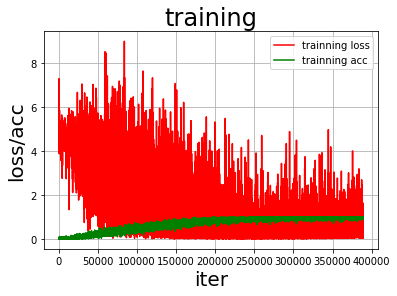

epoch  32 step    0: loss: 0.445940, acc: 1.000000
epoch  32 step  100: loss: 0.550617, acc: 0.968750
epoch  32 step  200: loss: 0.537682, acc: 1.000000
epoch  32 step  300: loss: 0.683183, acc: 0.937500
  train_pass:32,eval_acc=0.210029


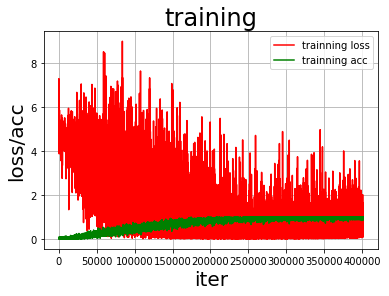

epoch  33 step    0: loss: 0.649222, acc: 0.968750
epoch  33 step  100: loss: 0.438450, acc: 1.000000
epoch  33 step  200: loss: 0.648190, acc: 0.968750
epoch  33 step  300: loss: 0.594963, acc: 0.968750
  train_pass:33,eval_acc=0.281250


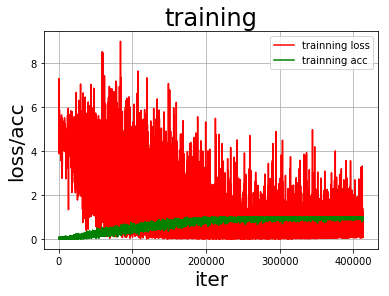

epoch  34 step    0: loss: 0.610522, acc: 1.000000
epoch  34 step  100: loss: 0.676821, acc: 0.968750
epoch  34 step  200: loss: 0.651927, acc: 1.000000
epoch  34 step  300: loss: 0.745660, acc: 1.000000
  train_pass:34,eval_acc=0.321221


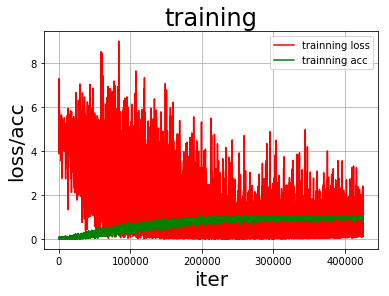

epoch  35 step    0: loss: 0.679520, acc: 1.000000
epoch  35 step  100: loss: 0.870338, acc: 0.937500
epoch  35 step  200: loss: 1.012505, acc: 0.906250
epoch  35 step  300: loss: 0.743130, acc: 1.000000
  train_pass:35,eval_acc=0.206395


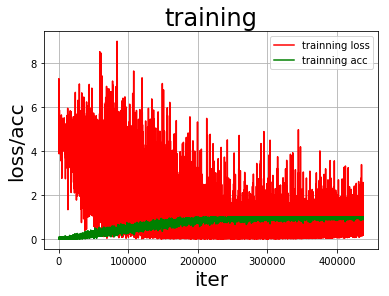

epoch  36 step    0: loss: 0.767099, acc: 1.000000
epoch  36 step  100: loss: 0.941368, acc: 1.000000
epoch  36 step  200: loss: 0.882985, acc: 0.968750
epoch  36 step  300: loss: 1.039371, acc: 0.937500
  train_pass:36,eval_acc=0.304506


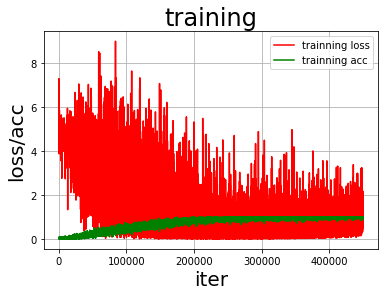

epoch  37 step    0: loss: 1.029496, acc: 0.968750
epoch  37 step  100: loss: 1.211408, acc: 0.968750
epoch  37 step  200: loss: 1.150821, acc: 0.968750
epoch  37 step  300: loss: 0.999373, acc: 1.000000
  train_pass:37,eval_acc=0.292878


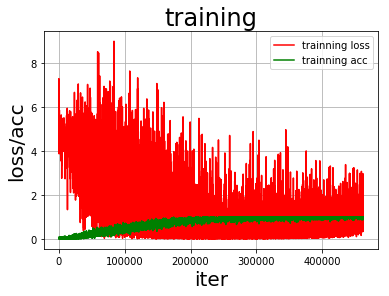

epoch  38 step    0: loss: 1.325539, acc: 1.000000
epoch  38 step  100: loss: 1.013076, acc: 1.000000
epoch  38 step  200: loss: 1.259703, acc: 0.968750
epoch  38 step  300: loss: 1.402914, acc: 0.968750
  train_pass:38,eval_acc=0.246366


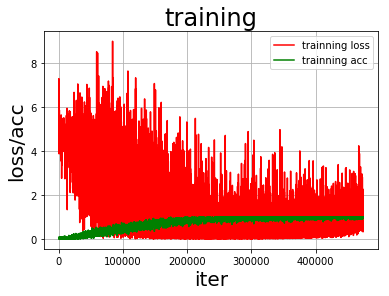

epoch  39 step    0: loss: 1.268695, acc: 0.968750
epoch  39 step  100: loss: 1.327611, acc: 0.968750
epoch  39 step  200: loss: 1.227099, acc: 1.000000
epoch  39 step  300: loss: 1.322204, acc: 1.000000
  train_pass:39,eval_acc=0.295785


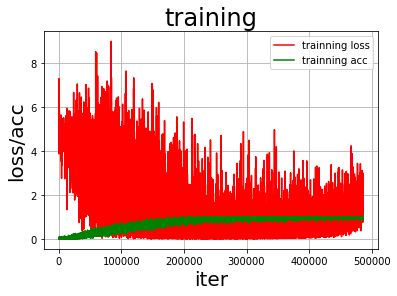

MyResNetG模型已保存
Final loss: [1.7271738]


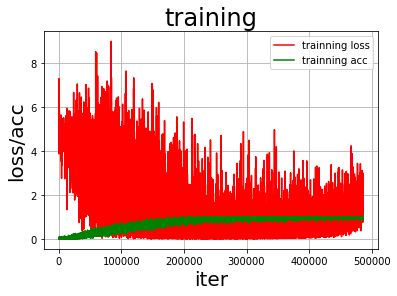

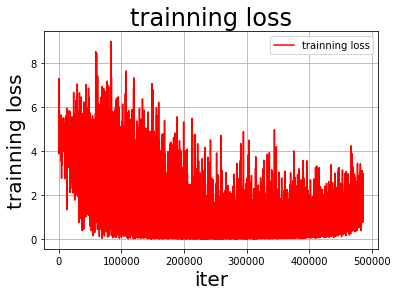

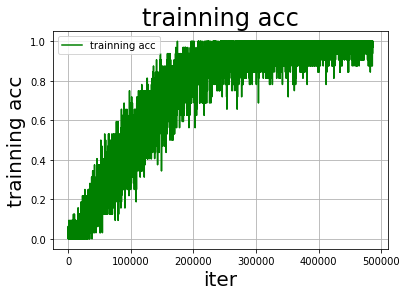

In [16]:
'''
模型训练，继续炼丹
'''
train_parameters["num_epochs"] = 40  # 设置轮次
epochs_num = train_parameters["num_epochs"]
batch_size = train_parameters["train_batch_size"] # train_parameters["learning_strategy"]["batch_size"]
total_images=train_parameters["image_count"]
stepsnumb = int(math.ceil(float(total_images) / batch_size))        

# resnet层数定义，要改一下
#train_parameters["layer"] = 50  

with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):   #使用GPU进行训练
##with fluid.dygraph.guard():                            #使用CPU进行训练
    print('class_dims:',train_parameters['class_dim'])
    print('label_dict:',train_parameters['label_dict'])

    best_acc = 0    
    best_epc = -1 
    eval_epchnumber = 0
    all_eval_avgacc = []
    all_eval_iters = []

    all_train_iter =0
    all_train_iters=[]
    all_train_costs=[]
    all_train_accs=[]

    model = ResNet("resnet", train_parameters["network_resnet"]["layer"], train_parameters["class_dim"])

    #"""
    if True:        
        try:
            if os.path.exists('MyResNet_best.pdparams'):
                print('try model file MyResNet_best. Loading...')
                model_dict, _ = fluid.load_dygraph('MyResNet_best')        
                if os.path.exists('beast_acc_ResNet.txt'):
                    with open('beast_acc_ResNet.txt', "r") as f:
                        best_acc = float(f.readline())
            else:
                print('try model file MyResNet. Loading...')
                model_dict, _ = fluid.load_dygraph('MyResNet')        
                if os.path.exists('acc_ResNet.txt'):
                    with open('acc_ResNet.txt', "r") as f:
                        best_acc = float(f.readline())
            #防止上一次acc太大，导致本次训练结果不存储了
            start_acc = min(0.92,train_parameters["early_stop"]["good_acc1"])
            if best_acc>=start_acc:
                best_acc=start_acc        
            model.load_dict(model_dict) #加载模型参数  
        except Exception as e:
            print(e)                
        print('model initialization finished.')
    #"""   

    #后面代码会切换工作模式
    model.train() #训练模式

    paramsList=model.parameters()
    params = train_parameters
    total_images = params["image_count"]
    ls = params["learning_strategy"]
    batch_size = ls["batch_size"]
    step = int(math.ceil(float(total_images) / batch_size))
    bd = [step * e for e in ls["epochs"]]
    # 固定学习率
    lr = 0.0000625 #params["learning_strategy"]["lr"]  #0.00125
    num_epochs = params["num_epochs"]
    regularization=fluid.regularizer.L2Decay(regularization_coeff=0.1)
    learning_rate=lr

    # 学习率衰减
    # learning_rate=fluid.layers.cosine_decay(
    #    learning_rate=lr, step_each_epoch=step, epochs=num_epochs)
    #momentum_rate = 0.9

    #定义优化方法 optimizer_momentum_setting, optimizer_sgd_setting, optimizer_rms_setting, optimizer_adam_setting, optimizer_Adamax_setting
    #optimizer = optimizer_momentum_setting(model.parameters())
    #optimizer = fluid.optimizer.Momentum(learning_rate=learning_rate,momentum=momentum_rate,regularization=regularization,parameter_list=paramsList)
    #optimizer=fluid.optimizer.SGDOptimizer(learning_rate=learning_rate, regularization=regularization, parameter_list=paramsList)
    optimizer=fluid.optimizer.AdamaxOptimizer(learning_rate=learning_rate, regularization=regularization, parameter_list=paramsList)
    #optimizer=fluid.optimizer.AdamOptimizer(learning_rate=learning_rate, regularization=regularization, parameter_list=paramsList) 

    #epochs_num = 1
     #开始训练
    for epoch_num in range(epochs_num):
        model.train() #训练模式
         #从train_reader中获取每个批次的数据
        for batch_id, data in enumerate(train_reader()):
            #dy_x_data = np.array([x[0] for x in data]).astype('float32')
            #y_data = np.array([x[1] for x in data]).astype('int')
            dy_x_data = np.array([x[0] for x in data]).astype('float32').reshape(-1, 3,224,224)
            y_data = np.array([x[1] for x in data]).astype('int64').reshape(-1,1)                               

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out,acc = model(img,label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)             
            #将参数梯度清零以保证下一轮训练的正确性
            model.clear_gradients()            

            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
            
            dy_param_value = {}
            for param in model.parameters():
                dy_param_value[param.name] = param.numpy
                
            if batch_id % 100 == 0 or batch_id == stepsnumb-1:
                print("epoch %3d step %4d: loss: %f, acc: %f" % (epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))

        if epoch_num % 1 == 0 or epoch_num == epochs_num-1:
            model.eval()      
            epoch_acc = eval_net(eval_reader, model) 
            print('  train_pass:%d,eval_acc=%f' % (epoch_num,epoch_acc))  
            eval_epchnumber = epoch_num
            all_eval_avgacc.append(epoch_acc)
            all_eval_iters.append([eval_epchnumber, epoch_acc])
                
            if best_acc < epoch_acc:  
                best_epc=epoch_num                                      
                best_acc=epoch_acc
                #保存模型参数，对应当前最好的评估结果
                fluid.save_dygraph(model.state_dict(),'MyResNet_best')
                print('    current best_eval_acc=%f in No.%d epoch' % (best_acc,best_epc)) 
                print('    MyResNet_best模型已保存')
                with open('beast_acc_ResNet.txt', "w") as f:
                    f.write(str(best_acc))
                #fluid.dygraph.save_dygraph(model.state_dict(), "save_dir/ResNet/model_best")
                #fluid.dygraph.save_dygraph(optimizer.state_dict(), "save_dir/ResNet/model_best")    

            #训练过程结果显示
            draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning loss","trainning acc")      
    
    #保存模型参数，但不一定是最好评估结果对应的模型
    fluid.save_dygraph(model.state_dict(), "MyResNet")   
    print('MyResNetG模型已保存')
    print("Final loss: {}".format(avg_loss.numpy()))
    #fluid.dygraph.save_dygraph(model.state_dict(), "save_dir/model")
    #fluid.dygraph.save_dygraph(optimizer.state_dict(), "save_dir/model")   
    with open('acc_ResNet.txt', "w") as f:
        f.write(str(epoch_acc)) 

    draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning loss","trainning acc")  
    draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
    draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")          

### 5.4.2 模型评估

In [17]:
'''
模型评估
'''
import numpy as np
import argparse
import ast
import paddle
import paddle.fluid as fluid
from paddle.fluid.layer_helper import LayerHelper
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, BatchNorm, Linear
from paddle.fluid.dygraph.base import to_variable
from paddle.fluid import framework
import math
import sys
from paddle.fluid.param_attr import ParamAttr

# resnet层数定义，要改一下
#train_parameters["layer"] = 50

with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):   #使用GPU进行训练
##with fluid.dygraph.guard():                            #使用CPU进行训练    
    model = ResNet("resnet", train_parameters["network_resnet"]["layer"], train_parameters["class_dim"])
    model_dict, _ = fluid.load_dygraph("MyResNet_best")    
    #model_dict, _ = fluid.dygraph.load_dygraph("save_dir/ResNet/model_best")
    model.load_dict(model_dict)
    model.eval()

    accs = []
    for batch_id, data in enumerate(eval_reader()):
        dy_x_data = np.array([x[0] for x in data]).astype('float32').reshape(-1,3,224,224)
        y_data = np.array([x[1] for x in data]).astype('int').reshape(-1,1)
        
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)

        out, acc = model(img, label)
        lab = np.argsort(out.numpy())
        accs.append(acc.numpy()[0])

    avg_acc = np.mean(accs)
    #print(np.mean(accs))
    print("模型校验avg_acc=",avg_acc)

模型校验avg_acc= 0.3866279


## 5.5 模型测试

### 5.5.1 测试数据准备

In [18]:
import os
import zipfile

def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data129412/sports_test.zip'
infer_dst_path = '/home/aistudio/data/sports_test'
unzip_infer_data(infer_src_path,infer_dst_path)

### 5.5.2 模型预测

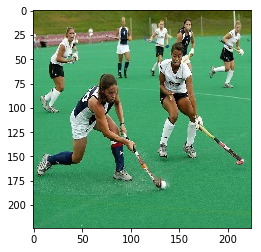

第1个样本,被预测为：lacrosse,真实标签为：field_hockey
第2个样本,被预测为：field_hockey,真实标签为：field_hockey
第3个样本,被预测为：field_hockey,真实标签为：field_hockey
第4个样本,被预测为：field_hockey,真实标签为：field_hockey
第5个样本,被预测为：field_hockey,真实标签为：field_hockey
结束


In [19]:
label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):   #使用GPU进行训练
##with fluid.dygraph.guard():                            #使用CPU进行训练 
    model = ResNet("resnet", train_parameters["network_resnet"]["layer"], train_parameters["class_dim"])
    model_dict, _ = fluid.load_dygraph("MyResNet_best")    
    #model_dict, _ = fluid.dygraph.load_dygraph("save_dir/ResNet/model_best")
    model.load_dict(model_dict)
    model.eval()

    #展示预测图片
    infer_path='data/sports_test/field_hockey' 
    infer_imag=os.path.join(infer_path,'4.jpg')        
    img = Image.open(infer_imag)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_path='data/sports_test/field_hockey'
    img_list = os.listdir(infer_path)
    if '__MACOSX' in img_list:
        img_list.remove('__MACOSX')    
    for imgfn in img_list:
        infer_imag=os.path.join(infer_path,imgfn)
        infer_imgs.append(load_image(infer_imag))
    infer_imgs = np.array(infer_imgs)
    
    for  i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = model(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
        print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split(".")[0]))  
print("结束")

# 6.项目总结与优化

## 6.1 项目总结

总结以上项目过程，本项目参考了一些优秀的开源项目和精品项目，在此要感谢飞桨平台上有着足够多的好项目可以进行学习，还要感谢官方团队的支持与鼓励。同时项目执行中还根据AI studio文档及教程进行自己想法的实现和完善，虽然时间很赶，对于Paddle框架的使用还不够熟练，好在总算是把这份项目完成了，没有被其他事情过多影响，也是值得庆幸的。算是一个小的历程碑吧，意味着勉强可以用飞桨来做小项目和应用了，不足之处还有很多，目前水平也有限，再接再厉吧。

## 6.2 项目优化

本项目在计划和实施的过程中，本着更多学习的目的，没有直接去使用高阶API函数和PaddleClas套件等较为简便的方式，后续若有时间，可能会单独另起一个项目来进行实现开发。此外，回顾作业一的计划方案，实际上在实现过程中并没有按照既定的方案那样去实施，可能时间和精力分配的还不够吧，后续若有闲暇，仍将把这个坑给填上。


## 6.3 项目开源

将本项目所有文件与代码进行开源，地址如下：

https://github.com/isLinXu/Paddle_SportsClassify

欢迎各位朋友Star和fork哦~

# 7.个人总结

虽然注册账号的时间很长，但真正接触使用飞桨才在不久前，因此水平有限，总难免会有不足之处，还请大家多多帮助，体谅下一些小错误。

另外简单介绍下自己吧~
作者：林旭，昵称isLinXu,目前在一家机器人公司担任视觉算法工程师，主要研究方向是目标检测、缺陷检测、对抗生成网络、模型压缩等。

博客园地址：https://www.cnblogs.com/isLinXu/
Github Page：https://islinxu.github.io/



